In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [11]:
# import pytorch specific utils

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchsummary import summary as torch_summary
from datetime import datetime
import hiddenlayer as hl

In [12]:
# create the transforms first.
train_transforms = transforms.Compose([
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.2
    ),
    transforms.RandomCrop(
        size=32,
        padding=4
    ),
    transforms.RandomHorizontalFlip(
        p=0.5
    ),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1)
    ),
    transforms.ToTensor()
])



# get the datasets
train_dataset = datasets.CIFAR10(
    root=".",
    train=True,
    transform=train_transforms,
    download=True

)

test_dataset = datasets.CIFAR10(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
epochs = 100
batch_size = 128


# construct the data loaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [27]:
# define the model
class CNN(nn.Module):
    def __init__(self, K, input):
        super(CNN, self).__init__()
        self.input = tuple(input)


        # define the con layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(4*4*128, 1024)
        self.fc2 = nn.Linear(1024, K)

    def summary(self):
        # input needs to be tuple
        torch_summary(self, input_size=self.input)

    def plot_model(self):
        # hl requires batch axis
        hl_input_size = [1] + list(self.input)
        hl_input = torch.zeros(hl_input_size,
                               dtype=torch.float32,
                               requires_grad=False)
        return hl.build_graph(self, hl_input)


    def forward(self, x) :
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)

        return x

In [28]:
# get the device and move model to device
model = CNN(K=10, input=(3, 32, 32))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

In [29]:
# get the summary of the model
model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6

c:\users\mhasa\google drive\tutorial corner\pyth\pycharm projects\deeplearningcv\venv\lib\site-packages\torch\onnx\symbolic_opset9.py:1168: UserWarning: Dropout is a training op and should not be exported in inference mode. Make sure to call eval() on the model, and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


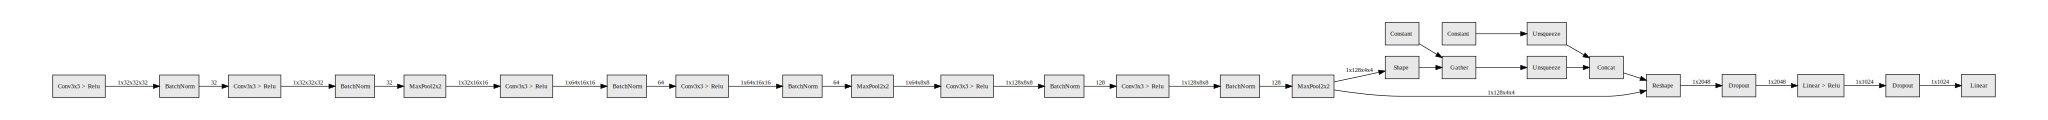

In [30]:
# plot the model
model.plot_model()

In [14]:
# create the loss and the optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [18]:
# train the model
epochs = 100

# stuff to store
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

train_accus = np.zeros(epochs)
test_accus = np.zeros(epochs)

for epoch in range(epochs):
    train_batch_losses = []
    test_batch_losses = []

    train_batch_accus = []
    test_batch_accus = []

    print("Training Network.....")
    for inputs, targets in train_loader:

        #move data to gpu
        inputs, targets = inputs.to(device), targets.to(device)


        # zero the grad
        optimizer.zero_grad()

        # forwards pass and get losses
        logits = model(inputs)
        train_batch_loss = criterion(logits, targets)
        train_batch_losses.append(train_batch_loss.item())

        # get accus
        # convert from logits to probabilities
        train_logit_probs = torch.exp(logits) / \
                            torch.sum(torch.exp(logits), dim=1).view(-1, 1)
        probs, indices = torch.topk(train_logit_probs, k=1, dim=1,)
        equals = targets.view(-1, 1) == indices
        train_batch_accu = np.mean(equals.detach().cpu().numpy())
        train_batch_accus.append(train_batch_accu)

        # BACKSTEP
        train_batch_loss.backward()
        optimizer.step()


    # Now validate
    print("Evaluating Network.....")
    with torch.no_grad():
        model.eval()

        for inputs, targets in test_loader:

            #move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)


            # forwards pass and get losses
            logits = model(inputs)
            test_batch_loss = criterion(logits, targets)
            test_batch_losses.append(test_batch_loss.item())

            # get accus
            # convert from logits to probabilities
            test_logit_probs = torch.exp(logits) / \
                                torch.sum(torch.exp(logits), dim=1).view(-1, 1)
            probs, indices = torch.topk(test_logit_probs, k=1, dim=1,)
            equals = targets.view(-1, 1) == indices
            test_batch_accu = np.mean(equals.cpu().numpy())
            test_batch_accus.append(test_batch_accu)


    model.train()
    print("=" * 50)
    # now getting out to the next epoch - all batches done - store epoch
    # loss and accus
    train_losses[epoch] = np.mean(train_batch_losses)
    test_losses[epoch] = np.mean(test_batch_losses)
    train_accus[epoch] = np.mean(train_batch_accus)
    test_accus[epoch] = np.mean(test_batch_accus)


    print(f"Epoch: {epoch+1}  TrainLoss: {train_losses[epoch]:0.3f}  "
          f"TestLoss: {test_losses[epoch]:0.3f}")
    print(f"TrainAcc: {train_accus[epoch]:0.3f}  TestAcc: {test_accus[epoch]:0.3f}")
    print("=" * 50)

Training Network.....
Evaluating Network.....
Epoch: 1  TrainLoss: 0.820  TestLoss: 0.639
TrainAcc: 0.713  TestAcc: 0.781
Training Network.....
Evaluating Network.....
Epoch: 2  TrainLoss: 0.724  TestLoss: 0.600
TrainAcc: 0.748  TestAcc: 0.795
Training Network.....
Evaluating Network.....
Epoch: 3  TrainLoss: 0.702  TestLoss: 0.584
TrainAcc: 0.757  TestAcc: 0.799
Training Network.....
Evaluating Network.....
Epoch: 4  TrainLoss: 0.680  TestLoss: 0.601
TrainAcc: 0.765  TestAcc: 0.790
Training Network.....
Evaluating Network.....
Epoch: 5  TrainLoss: 0.667  TestLoss: 0.548
TrainAcc: 0.772  TestAcc: 0.814
Training Network.....
Evaluating Network.....
Epoch: 6  TrainLoss: 0.648  TestLoss: 0.545
TrainAcc: 0.775  TestAcc: 0.816
Training Network.....
Evaluating Network.....
Epoch: 7  TrainLoss: 0.635  TestLoss: 0.546
TrainAcc: 0.781  TestAcc: 0.818
Training Network.....
Evaluating Network.....
Epoch: 8  TrainLoss: 0.620  TestLoss: 0.560
TrainAcc: 0.787  TestAcc: 0.811
Training Network.....
Ev

Evaluating Network.....
Epoch: 38  TrainLoss: 0.432  TestLoss: 0.411
TrainAcc: 0.850  TestAcc: 0.865
Training Network.....
Evaluating Network.....
Epoch: 39  TrainLoss: 0.424  TestLoss: 0.417
TrainAcc: 0.854  TestAcc: 0.863
Training Network.....
Evaluating Network.....
Epoch: 40  TrainLoss: 0.426  TestLoss: 0.393
TrainAcc: 0.854  TestAcc: 0.867
Training Network.....
Evaluating Network.....
Epoch: 41  TrainLoss: 0.418  TestLoss: 0.445
TrainAcc: 0.855  TestAcc: 0.856
Training Network.....
Evaluating Network.....
Epoch: 42  TrainLoss: 0.418  TestLoss: 0.380
TrainAcc: 0.854  TestAcc: 0.875
Training Network.....
Evaluating Network.....
Epoch: 43  TrainLoss: 0.414  TestLoss: 0.419
TrainAcc: 0.856  TestAcc: 0.861
Training Network.....
Evaluating Network.....
Epoch: 44  TrainLoss: 0.409  TestLoss: 0.388
TrainAcc: 0.857  TestAcc: 0.875
Training Network.....
Evaluating Network.....
Epoch: 45  TrainLoss: 0.405  TestLoss: 0.405
TrainAcc: 0.859  TestAcc: 0.867
Training Network.....
Evaluating Netwo

Evaluating Network.....
Epoch: 75  TrainLoss: 0.349  TestLoss: 0.380
TrainAcc: 0.879  TestAcc: 0.878
Training Network.....
Evaluating Network.....
Epoch: 76  TrainLoss: 0.353  TestLoss: 0.360
TrainAcc: 0.879  TestAcc: 0.880
Training Network.....
Evaluating Network.....
Epoch: 77  TrainLoss: 0.344  TestLoss: 0.381
TrainAcc: 0.880  TestAcc: 0.883
Training Network.....
Evaluating Network.....
Epoch: 78  TrainLoss: 0.344  TestLoss: 0.385
TrainAcc: 0.880  TestAcc: 0.884
Training Network.....
Evaluating Network.....
Epoch: 79  TrainLoss: 0.347  TestLoss: 0.376
TrainAcc: 0.880  TestAcc: 0.879
Training Network.....
Evaluating Network.....
Epoch: 80  TrainLoss: 0.340  TestLoss: 0.373
TrainAcc: 0.882  TestAcc: 0.881
Training Network.....
Evaluating Network.....
Epoch: 81  TrainLoss: 0.343  TestLoss: 0.384
TrainAcc: 0.880  TestAcc: 0.874
Training Network.....
Evaluating Network.....
Epoch: 82  TrainLoss: 0.337  TestLoss: 0.358
TrainAcc: 0.883  TestAcc: 0.884
Training Network.....
Evaluating Netwo

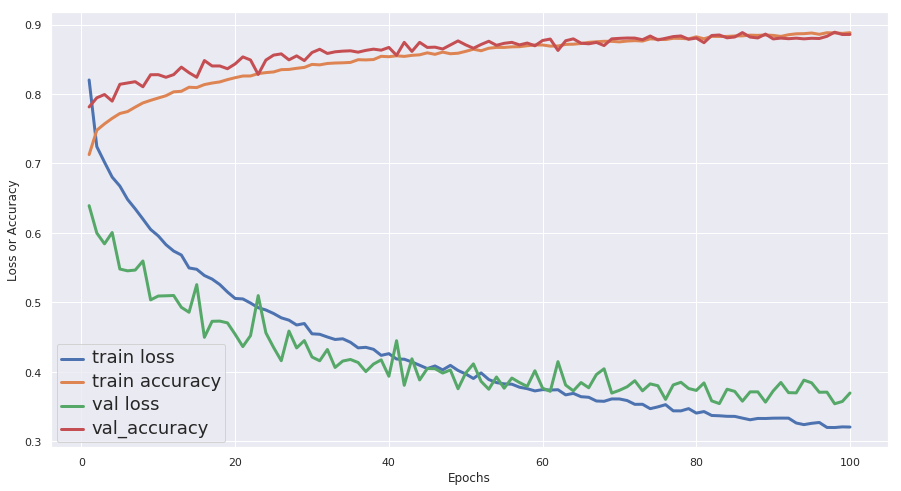

In [20]:

# plot the performance
epoch_num = range(1,epochs+1)
loss = train_losses
accuracy = train_accus
val_loss = test_losses
val_accuracy = test_accus
plot_df = pd.DataFrame(data=np.c_[epoch_num,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [27]:
# evaluate the network for confusion matrix and classification report
x_test = test_dataset.data
y_test = np.array(test_dataset.targets).reshape(-1, 1)
p_test = np.array([]).reshape(0, 1)

with torch.no_grad():
        model.eval()
        for inputs, targets in test_loader:
            
            #move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)

            # forwards pass and get losses
            logits = model(inputs)

            # get accus
            # convert from logits to probabilities
            test_logit_probs = torch.exp(logits) / \
                                torch.sum(torch.exp(logits), dim=1).view(-1, 1)
            probs, indices = torch.topk(test_logit_probs, k=1, dim=1,)
            equals = targets.view(-1, 1) == indices
            
            # i are indices with highest probs predicted by the network
            i = indices.cpu().numpy()
            p_test = np.concatenate((p_test, i))

In [28]:
# evaluate the network - get classification matrix
from sklearn.metrics import classification_report, confusion_matrix
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print (classification_report(y_test,p_test, target_names=classNames))

              precision    recall  f1-score   support

    airplane       0.88      0.91      0.89      1000
  automobile       0.96      0.93      0.95      1000
        bird       0.89      0.79      0.84      1000
         cat       0.76      0.78      0.77      1000
        deer       0.87      0.88      0.87      1000
         dog       0.84      0.84      0.84      1000
        frog       0.94      0.90      0.92      1000
       horse       0.91      0.93      0.92      1000
        ship       0.93      0.94      0.93      1000
       truck       0.90      0.96      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [30]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

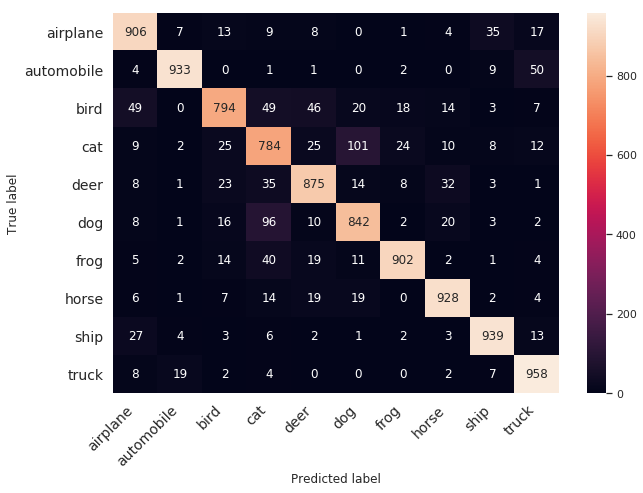

In [31]:
# draw the confusion matrix
cm = confusion_matrix(y_test, p_test)
print_confusion_matrix(cm, class_names=classNames)

Actual: airplane but Predicted: truck


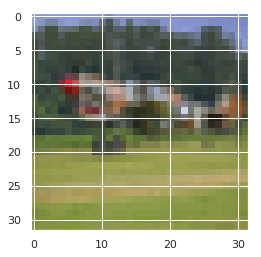

In [38]:
# show some misclassified examples
# y_test contains actual label, p_test contains predicted labels

missmatch_indices = np.nonzero(p_test != y_test)[0]
x_test = test_dataset.data

# grab a mismatched x
idx = np.random.choice(missmatch_indices)
x_miss = x_test[idx]
miss_label = int(p_test[idx][0])
actual_label = int(y_test[idx][0])

# now plot
print(f"Actual: {classNames[actual_label]} but Predicted: {classNames[miss_label]}")
plt.imshow(x_miss, cmap='gray');
